##### Testing di vari modelli di deep learning su dataset unito

In [1]:
from fastai.tabular.all import *
from warnings import simplefilter
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from pytorch_widedeep.preprocessing import TabPreprocessor
from pytorch_widedeep.models import *
from pytorch_widedeep import Trainer
from pytorch_widedeep.metrics import Accuracy
from torch.optim import SGD, lr_scheduler
from pytorch_widedeep.initializers import XavierNormal
from pytorch_widedeep.utils import LabelEncoder
from pytorch_widedeep.self_supervised_training import ContrastiveDenoisingTrainer
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import hyperopt
import catboost as cb
import lightgbm as lgb
set_seed(42)
simplefilter(action="ignore", category=FutureWarning)

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


*Pulizia dati cromosoma 22*

In [2]:
df = pd.read_csv('clinvar.22.dbnsfp.vcf', sep='\t')
df = df.apply(lambda x: x.str.split(';') if x.dtype == "object" else x)
df = df.map(lambda x: x.remove('') if type(x) is list and '' in x else x)

l = []

for col in df.columns:
    if df[col].apply(lambda x: len(x) if type(x) is list else list()).equals(df['aapos'].apply(lambda x: len(x) if type(x) is list else list())):
        l.append(col)

l.append('TSL')
df = df.explode(l)
df = df.map(lambda x: x[0] if type(x) is list and len(x) == 1 else x)
df.replace(to_replace='.', value=np.nan, inplace=True)
df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
####
#df.dropna(axis='columns', thresh=int(len(df.index)*0.8), inplace=True)
####
df = df.apply(pd.to_numeric, errors='ignore')


l1 = []

for col in df.columns:
    if df[col].map(lambda x: True if type(x) is list else False).any():
        l1.append(col)

for col in l1:
    v = df[col].explode().value_counts()
    toRemove = v[v < int(len(df[col].explode()) * 0.10)].index
    df[col] = df[col].map(lambda x: [i for i in x if i not in toRemove] if type(x) is list else x)

/tmp/ipykernel_59583/1942847823.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('clinvar.22.dbnsfp.vcf', sep='\t')


In [3]:
df.apply(pd.to_numeric, errors='ignore')
#df.replace(to_replace=np.nan, value=0, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'not_provided'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'protective'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'drug_response'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'association'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Affects'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'other'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'drug_response,_risk_factor'].index, inplace=True)
df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
df.replace(to_replace='Benign/Likely_benign', value='Likely_benign', inplace=True)
df.replace(to_replace='Likely_benign,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Likely_benign,_drug_response,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Benign/Likely_benign,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Likely_pathogenic', inplace=True)
df.replace(to_replace='Benign/Likely_benign,_risk_factor', value='Likely_pathogenic', inplace=True)
df.reset_index(drop=True, inplace=True)

*Pulizia cromosoma 21*

In [4]:
df1 = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')
df1 = df1.apply(lambda x: x.str.split(';') if x.dtype == "object" else x)
df1 = df1.map(lambda x: x.remove('') if type(x) is list and '' in x else x)

l = []

for col in df1.columns:
    if df1[col].apply(lambda x: len(x) if type(x) is list else list()).equals(df1['aapos'].apply(lambda x: len(x) if type(x) is list else list())):
        l.append(col)

l.append('TSL')
df1 = df1.explode(l)
df1 = df1.map(lambda x: x[0] if type(x) is list and len(x) == 1 else x)
df1.replace(to_replace='.', value=np.nan, inplace=True)
df1.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
#####
#df1.dropna(axis='columns', thresh=int(len(df1.index)*0.8), inplace=True)
#####
df1 = df1.apply(pd.to_numeric, errors='ignore')


l1 = []

for col in df1.columns:
    if df1[col].map(lambda x: True if type(x) is list else False).any():
        l1.append(col)

for col in l1:
    v = df1[col].explode().value_counts()
    toRemove = v[v < int(len(df1[col].explode()) * 0.10)].index
    df1[col] = df1[col].map(lambda x: [i for i in x if i not in toRemove] if type(x) is list else x)

/tmp/ipykernel_59583/800033988.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')


In [5]:
df1.apply(pd.to_numeric, errors='ignore')
#df1.replace(to_replace=np.nan, value=0, inplace=True)
df1.drop(axis='index', labels=df1[df1.clinvar_clnsig == 'not_provided'].index, inplace=True)
df1.drop(axis='index', labels=df1[df1.clinvar_clnsig == 'protective'].index, inplace=True)
df1.drop(axis='index', labels=df1[df1.clinvar_clnsig == 'risk_factor'].index, inplace=True)
df1.drop(axis='index', labels=df1[df1.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
df1.drop(axis='index', labels=df1[df1.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
df1.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
df1.replace(to_replace='Benign/Likely_benign', value='Benign', inplace=True)
df1.replace(to_replace='Pathogenic/Likely_pathogenic', value='Pathogenic', inplace=True)
df1.reset_index(drop=True, inplace=True)

*Pulizia cromosoma 20*

In [6]:
df2 = pd.read_csv('dbsnp.common.20.intervar.hg19_multianno.txt', sep='\t')
df2 = df2.drop(df2[df2['CLNSIG'] == '.'].index)
df2 = df2.map(lambda x: x.split(';') if type(x) is str and len(x.split(';')) > 1 else x)
df2 = df2.map(lambda x: x.remove('') if type(x) is list and '' in x else x)
l = []

for col in df2.columns:
    if df2[col].apply(lambda x: True if type(x) is list and len(x) > 2 else False).any():
        l.append(col)

for col in l:
    if col == 'Interpro_domain':
        df2 = df2.explode(col)
    else:
        df2.drop(col, axis=1, inplace=True)

df2 = df2.map(lambda x: x[0] if type(x) is list else x)
df2.replace(to_replace='.', value=np.nan, inplace=True)
df2.dropna(axis='rows', how='any', inplace=True, subset=['CLNSIG'])
#df2.dropna(axis='columns', thresh=int(len(df2.index)*0.8), inplace=True)
df2 = df2.apply(pd.to_numeric, errors='ignore')

df2.apply(pd.to_numeric, errors='ignore')
#df2.replace(to_replace=np.nan, value=0, inplace=True)
df2.drop(axis='index', labels=df2[df2.CLNSIG == 'not_provided'].index, inplace=True)
df2.drop(axis='index', labels=df2[df2.CLNSIG == 'protective'].index, inplace=True)
df2.drop(axis='index', labels=df2[df2.CLNSIG == 'risk_factor'].index, inplace=True)
df2.drop(axis='index', labels=df2[df2.CLNSIG == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
df2.drop(axis='index', labels=df2[df2.CLNSIG == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
df2.drop(axis='index', labels=df2[df2.CLNSIG == 'association'].index, inplace=True)
df2.drop(axis='index', labels=df2[df2.CLNSIG == 'drug_response'].index, inplace=True)
df2.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
df2.replace(to_replace='Benign/Likely_benign', value='Benign', inplace=True)
df2.replace(to_replace='Pathogenic/Likely_pathogenic', value='Pathogenic', inplace=True)
df2.reset_index(drop=True, inplace=True)
df2 = df2.rename({"CLNSIG": "clinvar_clnsig", "Ref": "ref", "Alt": "alt", "Chr": "#chr"}, axis="columns")

In [7]:
a = np.intersect1d(df.columns, df1.columns)
b = np.intersect1d(df2.columns, a)
df_concat = pd.concat([df[b], df1[b], df2[b]])
df_concat.dropna(axis='columns', thresh=int(len(df2.index)*0.8), inplace=True)
df_concat.replace(to_replace=np.nan, value=0, inplace=True)
df_concat.replace(to_replace='-', value=0, inplace=True)

In [8]:
l2 = []

for col in df_concat.columns:
    if df_concat[col].map(lambda x: True if type(x) is list else False).any():
        l2.append(col)

df_concat.drop(axis='columns', labels=l2, inplace=True)

In [9]:
df_concat['clinvar_clnsig'].value_counts()

clinvar_clnsig
Uncertain_significance    38061
Pathogenic                 6415
Benign                     5634
Likely_pathogenic          3979
Likely_benign              3101
Name: count, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

df_concat, df_test = train_test_split(df_concat, test_size=0.2)

In [11]:
df_data = df_concat.drop(columns=['clinvar_clnsig'], inplace=False)
num_cols = df_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_data.select_dtypes(include=[object]).columns.tolist()
df_concat = df_concat.sample(frac=1).reset_index(drop=True)

In [12]:
encoder = LabelEncoder(["clinvar_clnsig"])
df_concat = encoder.fit_transform(df_concat)
df_concat["clinvar_clnsig"] = df_concat["clinvar_clnsig"] - 1

In [13]:

target = 'clinvar_clnsig'
target = df_concat[target].values

In [14]:
embed_cols = [(col, 40) for col in cat_cols]

In [15]:
tab_preprocessor = TabPreprocessor(
    cat_embed_cols=embed_cols, 
    continuous_cols=num_cols 
)

In [16]:
X_tab = tab_preprocessor.fit_transform(df_concat)

/home/andrea/.local/lib/python3.10/site-packages/pytorch_widedeep/preprocessing/tab_preprocessor.py:360: UserWarning: Continuous columns will not be normalised
  warnings.warn("Continuous columns will not be normalised")


- TabMlp

In [17]:
tab_mlp = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)

In [18]:
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)

In [19]:
deep_opt = SGD(model.deeptabular.parameters(), lr=0.001)

In [20]:
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)

In [21]:
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda')

In [22]:
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,
)

valid: 100%|██████████| 36/36 [00:00<00:00, 61.67it/s, loss=0.356, metrics={'acc': 0.8848}]


In [23]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)

predict: 100%|██████████| 45/45 [00:00<00:00, 84.10it/s] 


In [24]:
d = encoder.create_inverse_encoding_dict()

In [25]:
e = d['clinvar_clnsig']

In [26]:
preds = [e[i+1] for i in preds]

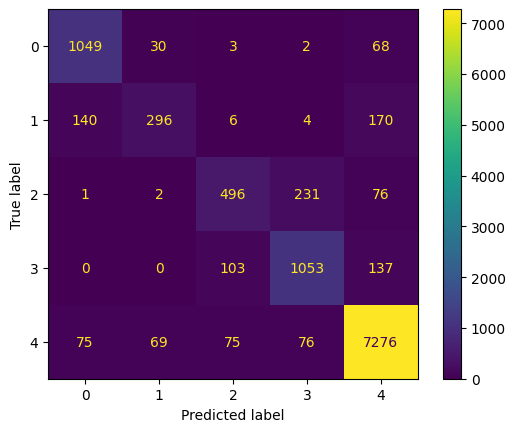

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

- ContextAttentionMLP

In [28]:
tab_mlp = ContextAttentionMLP(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda')
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,
)

valid: 100%|██████████| 36/36 [00:00<00:00, 70.59it/s, loss=0.951, metrics={'acc': 0.6987}]


predict: 100%|██████████| 45/45 [00:00<00:00, 84.57it/s] 


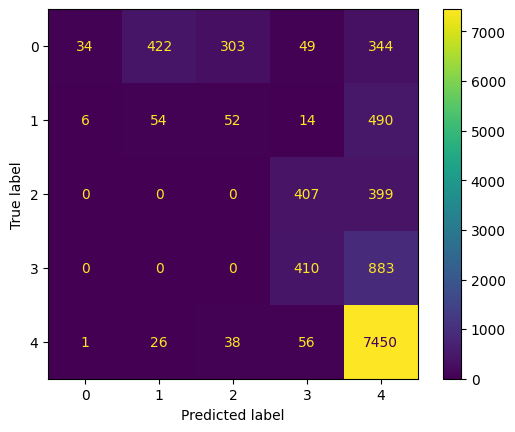

In [29]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

- SelfAttentionMLP

In [30]:
tab_mlp = SelfAttentionMLP(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda')
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,
)

valid: 100%|██████████| 36/36 [00:00<00:00, 49.72it/s, loss=0.455, metrics={'acc': 0.8294}]


predict: 100%|██████████| 45/45 [00:00<00:00, 60.89it/s]


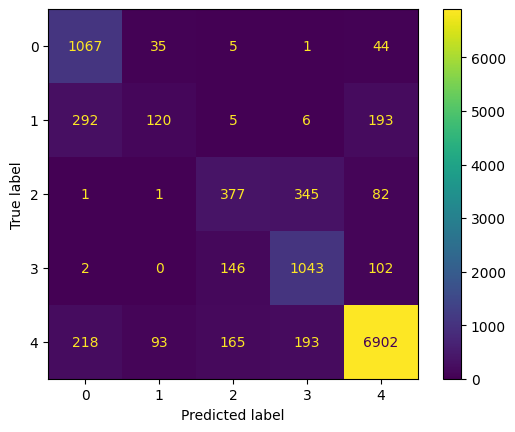

In [31]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

- TabResnet

In [32]:
tab_mlp = TabResnet(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda')
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,
)

valid: 100%|██████████| 36/36 [00:00<00:00, 61.19it/s, loss=0.329, metrics={'acc': 0.8967}]


predict: 100%|██████████| 45/45 [00:00<00:00, 74.37it/s]


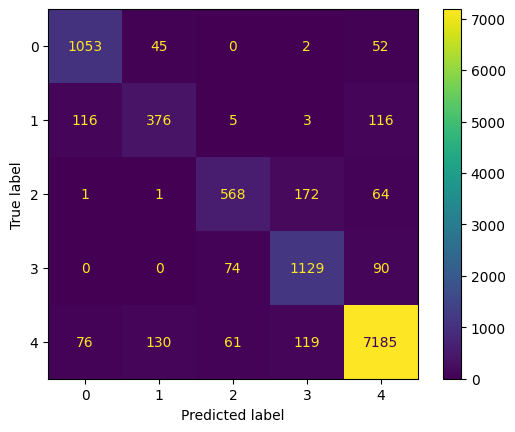

In [33]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

- Tabnet

In [34]:
tab_mlp = TabNet(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda', lr_schedulers={"deeptabular": deep_sch})
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,   
)

valid: 100%|██████████| 36/36 [00:00<00:00, 38.92it/s, loss=1.29, metrics={'acc': 0.6233}]
/home/andrea/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
valid: 100%|██████████| 36/36 [00:01<00:00, 33.25it/s, loss=0.573, metrics={'acc': 0.8144}]


predict: 100%|██████████| 45/45 [00:00<00:00, 45.21it/s]


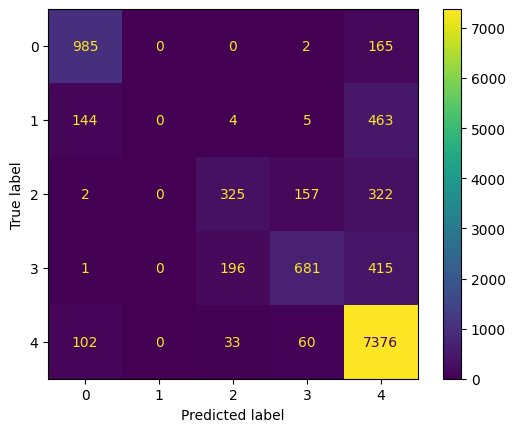

In [35]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

- TabTransformer

In [36]:
tab_mlp = TabTransformer(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda', lr_schedulers={"deeptabular": deep_sch})
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,   
)

valid: 100%|██████████| 36/36 [00:00<00:00, 58.56it/s, loss=0.391, metrics={'acc': 0.865}] 


predict: 100%|██████████| 45/45 [00:00<00:00, 75.11it/s]


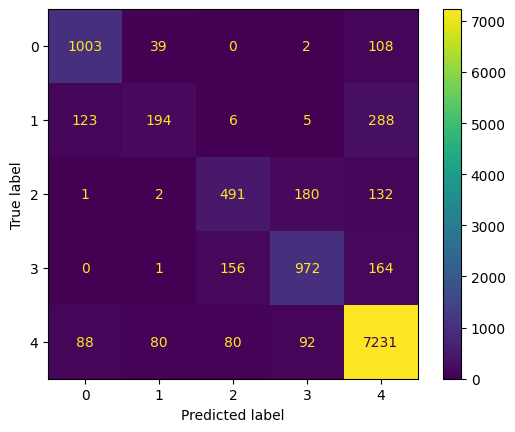

In [37]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

- FTTransformer

In [38]:
tab_mlp = FTTransformer(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda', lr_schedulers={"deeptabular": deep_sch})
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,   
)

valid: 100%|██████████| 36/36 [00:00<00:00, 44.92it/s, loss=0.327, metrics={'acc': 0.9102}]


predict: 100%|██████████| 45/45 [00:00<00:00, 52.36it/s]


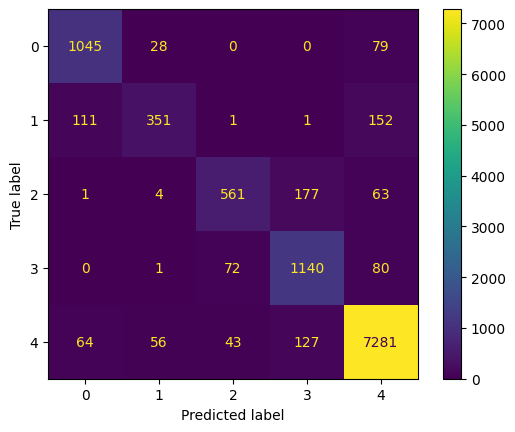

In [39]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

- SAINT

In [40]:
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda', lr_schedulers={"deeptabular": deep_sch})
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,   
)

valid: 100%|██████████| 36/36 [00:00<00:00, 42.19it/s, loss=0.355, metrics={'acc': 0.9248}]


predict: 100%|██████████| 45/45 [00:00<00:00, 49.98it/s]


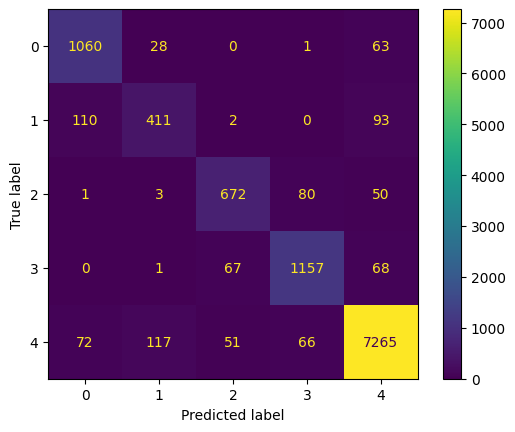

In [41]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

- TabFastFormer

In [42]:
tab_mlp = TabFastFormer(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda', lr_schedulers={"deeptabular": deep_sch})
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,   
)

valid: 100%|██████████| 36/36 [00:00<00:00, 50.30it/s, loss=0.386, metrics={'acc': 0.8685}]


predict: 100%|██████████| 45/45 [00:00<00:00, 60.94it/s]


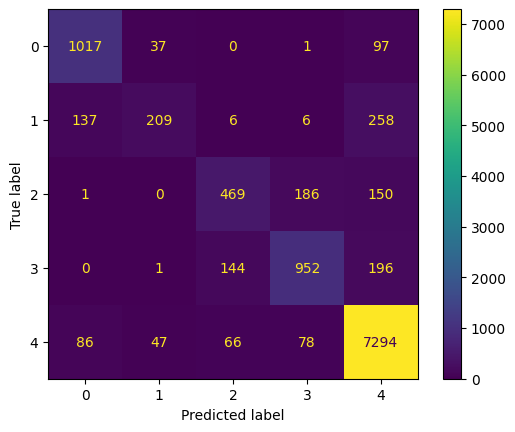

In [43]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

- TabPerceiver

In [44]:
tab_mlp = TabPerceiver(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda', lr_schedulers={"deeptabular": deep_sch})
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,   
)

valid: 100%|██████████| 36/36 [00:01<00:00, 31.37it/s, loss=0.437, metrics={'acc': 0.8361}]


predict: 100%|██████████| 45/45 [00:01<00:00, 37.84it/s]


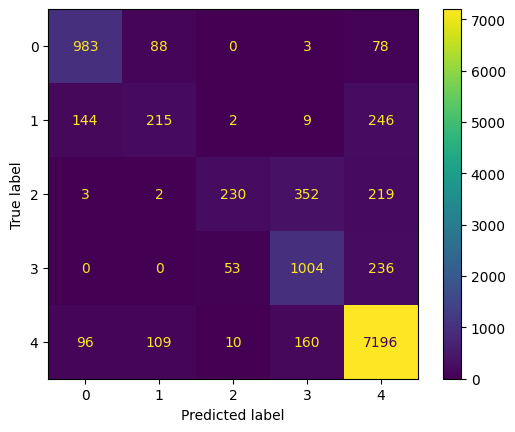

In [45]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

- CatBoost

In [31]:
df_concat.head()

,#chr,BayesDel_addAF_pred,BayesDel_addAF_rankscore,BayesDel_addAF_score,BayesDel_noAF_pred,BayesDel_noAF_rankscore,BayesDel_noAF_score,CADD_phred,CADD_raw,CADD_raw_rankscore,...,integrated_fitCons_score,phastCons100way_vertebrate,phastCons100way_vertebrate_rankscore,phastCons30way_mammalian,phastCons30way_mammalian_rankscore,phyloP100way_vertebrate,phyloP100way_vertebrate_rankscore,phyloP30way_mammalian,phyloP30way_mammalian_rankscore,ref
0,22,D,0.73632,0.197217,D,0.73287,0.045511,26.900,3.991176,0.78306,...,0.706548,1.0,0.71638,0.991,0.53220,7.069,0.76447,1.302,0.87932,A
1,22,T,0.00000,0.000000,T,0.00000,0.000000,31.000,4.393673,0.90008,...,0.706548,1.0,0.71638,1.000,0.86279,3.991,0.56684,1.025,0.40714,C
2,22,T,0.00000,0.000000,T,0.00000,0.000000,0.432,-0.233945,0.02669,...,0.706548,0.0,0.06391,0.000,0.01923,-0.484,0.06608,-0.718,0.03795,C
3,22,D,0.99412,0.625005,D,0.99401,0.660000,42.000,8.276914,0.99099,...,0.562547,1.0,0.71638,1.000,0.86279,9.128,0.93719,1.176,0.78918,G
4,22,D,0.99412,0.625005,D,0.99401,0.660000,37.000,7.019629,0.97096,...,0.706298,1.0,0.71638,0.999,0.70432,1.114,0.30811,1.026,0.45946,C


In [32]:
y = df_concat['clinvar_clnsig']
X = df_concat.drop(columns=['clinvar_clnsig'], inplace=False)
for col in cat_cols:
    X[col] = X[col].map(lambda x: str(x))

In [33]:
train_pool = Pool(X, y, cat_features=cat_cols)

In [82]:
model = CatBoostClassifier(iterations=200, learning_rate=0.1, loss_function='MultiClass', eval_metric='Accuracy')

In [83]:
model.fit(X, y, cat_features=cat_cols)

0:	learn: 0.8142158	total: 709ms	remaining: 2m 21s
1:	learn: 0.8157895	total: 1.57s	remaining: 2m 35s
2:	learn: 0.8184342	total: 2.35s	remaining: 2m 34s
3:	learn: 0.8182375	total: 2.79s	remaining: 2m 16s
4:	learn: 0.8203139	total: 3.48s	remaining: 2m 15s
5:	learn: 0.8208821	total: 3.98s	remaining: 2m 8s
6:	learn: 0.8231334	total: 4.51s	remaining: 2m 4s
7:	learn: 0.8228711	total: 5.04s	remaining: 2m
8:	learn: 0.8236361	total: 5.53s	remaining: 1m 57s
9:	learn: 0.8226744	total: 6.03s	remaining: 1m 54s
10:	learn: 0.8267835	total: 6.58s	remaining: 1m 53s
11:	learn: 0.8271988	total: 7.05s	remaining: 1m 50s
12:	learn: 0.8278545	total: 7.59s	remaining: 1m 49s
13:	learn: 0.8295375	total: 8.1s	remaining: 1m 47s
14:	learn: 0.8307615	total: 8.71s	remaining: 1m 47s
15:	learn: 0.8304336	total: 9.35s	remaining: 1m 47s
16:	learn: 0.8308926	total: 9.88s	remaining: 1m 46s
17:	learn: 0.8321385	total: 10.5s	remaining: 1m 46s
18:	learn: 0.8324008	total: 11.1s	remaining: 1m 45s
19:	learn: 0.8329253	total: 1

In [84]:
y_test = df_test['clinvar_clnsig']
X_Test = df_test.drop(columns=['clinvar_clnsig'], inplace=False)
for col in cat_cols:
    X_Test[col] = X_Test[col].map(lambda x: str(x))

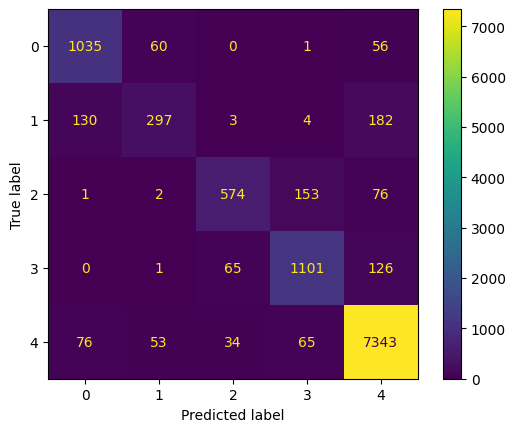

In [85]:
preds = model.predict(X_Test)
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

- LightGBM

In [12]:
X = df_concat
cat_cols.append('clinvar_clnsig')
for col in cat_cols:
    X[col] = X[col].astype('category')
    X[col] = df[col].apply(lambda x: x.cat.codes)
y = X['clinvar_clnsig']

In [13]:
train_data = lgb.Dataset(X, label=y, categorical_feature=cat_cols, feature_name=X.columns.tolist())

In [14]:
num_round = 1
param = {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss'}
bst = lgb.train(param, train_data, num_round)

: 

: 